In [1]:
from inference_video import predict_video
import os
from tqdm import tqdm
from model import MODEL
import torch
from ultralytics import YOLO
from video_utils import *
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
device = "mps" if torch.backends.mps.is_available() else device

print("Device: ", device)

Device:  cuda


In [2]:
model = MODEL("weights/best.pt", device)
yolo = YOLO("weights/best.pt")
yolo.names

{0: 'basketball', 1: 'hoop', 2: 'person'}

In [2]:
test_dataset_path = "video_test_dataset/"
mades = os.listdir(test_dataset_path + '1')
misses = os.listdir(test_dataset_path + '0')
# remove ".DS_Store" file if it exists
if ".DS_Store" in mades:
    mades.remove(".DS_Store")
if ".DS_Store" in misses:
    misses.remove(".DS_Store")
    
actual = [1] * len(mades) + [0] * len(misses)
predictions = []

for made in tqdm(mades):
    video_path = test_dataset_path + '1/' + made
    pred = predict_video(video_path, 
                         #model = model, 
                         batch_size=32,
                         show_progress=False,
                         write_video=False)
    
    predictions.append(pred)
    
for miss in tqdm(misses):
    video_path = test_dataset_path + '0/' + miss
    pred = predict_video(video_path, 
                         # model = model, 
                         batch_size=32,
                         show_progress=False,
                         write_video=False)
    
    predictions.append(pred)
    

  6%|▌         | 5/84 [00:06<01:45,  1.33s/it]


KeyboardInterrupt: 

In [76]:
# make confusion matrix
from sklearn.metrics import confusion_matrix, classification_report, ConfusionMatrixDisplay

              precision    recall  f1-score   support

        Miss       0.85      0.74      0.79        87
        Made       0.76      0.87      0.81        84

    accuracy                           0.80       171
   macro avg       0.81      0.80      0.80       171
weighted avg       0.81      0.80      0.80       171



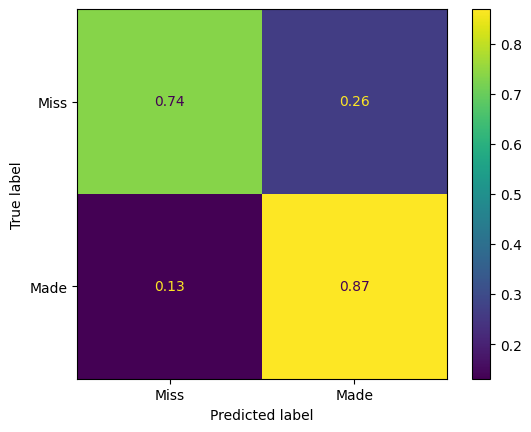

In [77]:
# change any value > 1 to 1 in predictions
predictions = [1 if pred > 0 else 0 for pred in predictions]
ConfusionMatrixDisplay(confusion_matrix(actual, predictions, normalize='true'), display_labels=['Miss', 'Made']).plot();
print(classification_report(actual, predictions, target_names=['Miss', 'Made']))

In [86]:
false_positive_vids = [vid for vid, pred, actual_ in zip(misses, predictions[len(mades):], actual[len(mades):]) if pred == 1]
false_negative_vids = [vid for vid, pred, actual_ in zip(mades, predictions[:len(mades)], actual[:len(mades)]) if pred == 0]

# Example False Positives

In [6]:
predict_video(test_dataset_path + '0/' + false_positive_vids[0], 
              model=model,
              write_video=True,
              )
display_video('output.mp4')

NameError: name 'test_dataset_path' is not defined

In [ ]:
print(predict_video(test_dataset_path + '0/' + false_positive_vids[-1], 
              model=model,
              write_video=True,
              ))
display_video('output.mp4')

False positives occur every time a ball goes through the highlighted boxes. Without depth perception, it is impossible to address this problem because we know is the coordinates of the objects

# Example False Negatives

In [ ]:
print(predict_video(test_dataset_path + '1/' + false_negative_vids[-1], 
              model=model,
              write_video=True,
              ))
display_video('output.mp4')

In [ ]:
print(predict_video(test_dataset_path + '1/' + false_negative_vids[6], 
              model=model,
              write_video=True,
              ))
display_video('output.mp4')

In [ ]:
print(predict_video(test_dataset_path + '1/' + false_negative_vids[7], 
              model=model,
              write_video=True,
              ))
display_video('output.mp4')

In all these examples, the model failed to detect the balls and sometimes the baskets in the videos.